In [1]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch.optim import Adam
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.nn import Linear

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/kaggle/input/autoencoder-data/quark-gluon_data-set_n139306.hdf5"

In [4]:
print(device)

cuda


In [5]:
def explore_hdf5(file):
    with h5py.File(file, "r") as f:
        print("Keys in dataset:", list(f.keys()))
        for key in f.keys():
            print(f"Shape of {key}: {f[key].shape}")

explore_hdf5(file_path)

Keys in dataset: ['X_jets', 'm0', 'pt', 'y']
Shape of X_jets: (139306, 125, 125, 3)
Shape of m0: (139306,)
Shape of pt: (139306,)
Shape of y: (139306,)


In [6]:
def load_data(file_name, sample_size):
    with h5py.File(file_name, 'r') as f:
        print("Dataset keys:", list(f.keys()))
        print("Total images:", len(f['X_jets']))
        print("Image dimensions:", f['X_jets'].shape[1:])
        X = np.array(f['X_jets'][:sample_size])
        y = np.array(f['y'][:sample_size], dtype=np.int64) 
        metadata = np.column_stack((f['m0'][:sample_size], f['pt'][:sample_size])) 
    return X, y, metadata

X, y, metadata = load_data(file_path, 10000)

Dataset keys: ['X_jets', 'm0', 'pt', 'y']
Total images: 139306
Image dimensions: (125, 125, 3)


In [7]:
def preprocess_images(images):
    from skimage.transform import resize
    # Resize to 128x128 and normalize
    processed = np.array([resize(img, (128, 128), anti_aliasing=True) for img in images], dtype=np.float32)
    mean, std = np.mean(processed), np.std(processed)
    return np.clip((processed - mean) / std, 0, None)

X = preprocess_images(X)

In [8]:
def normalize_metadata(metadata):
    mean, std = np.mean(metadata, axis=0), np.std(metadata, axis=0)
    return (metadata - mean) / std

metadata = normalize_metadata(metadata)

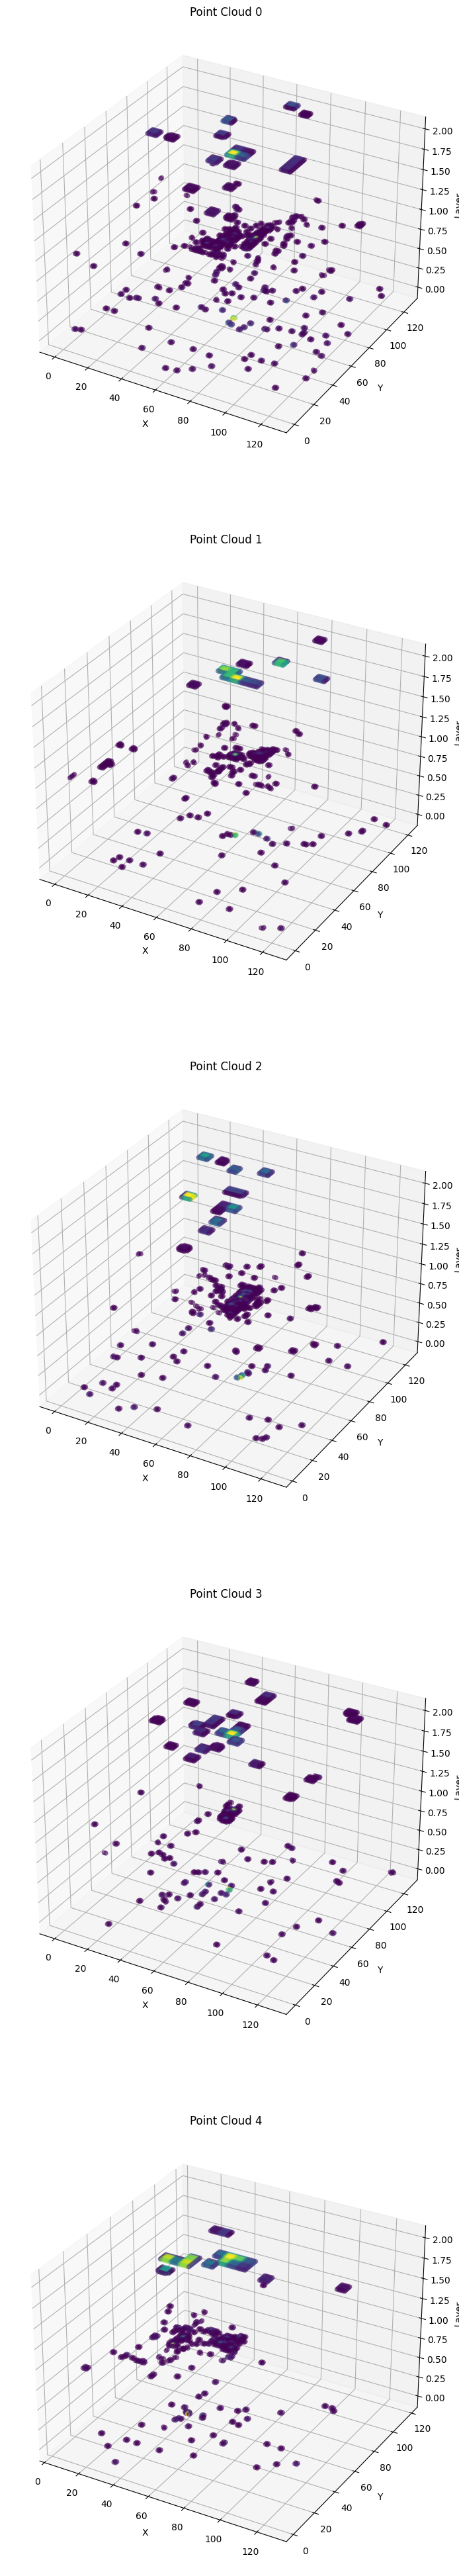

In [9]:
def visualize_point_cloud(images, labels, num_samples=5):
    point_clouds = []
    fig = plt.figure(figsize=(10, 50))
    
    for idx in range(num_samples):
        ax = fig.add_subplot(num_samples, 1, idx + 1, projection='3d')
        cloud_data = {}
        
        for channel, offset, name in zip(range(3), [0, 1, 2], ['tracks', 'ECAL', 'HCAL']):
            non_zero = np.nonzero(images[idx, :, :, channel])
            coords = np.column_stack(non_zero)
            values = images[idx, non_zero[0], non_zero[1], channel]
            coords = np.hstack((coords, np.full((coords.shape[0], 1), offset)))
            cloud_data[name] = (coords, values)
            ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=values, cmap='viridis', alpha=0.5)
        
        point_clouds.append(cloud_data)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Layer')
        ax.set_title(f'Point Cloud {idx}')
    
    plt.show()
    

visualize_point_cloud(X, y)

In [10]:
def extract_nonzero_mask(images):
    reshaped = images.reshape((-1, images.shape[1] * images.shape[2], 3))
    return np.any(reshaped != [0., 0., 0.], axis=-1).reshape(images.shape[:3])

mask = extract_nonzero_mask(X)

In [11]:
def create_graph_features(masked_data):
    indices, features = [], []
    for img_idx, mask in enumerate(masked_data):
        coords = np.column_stack(np.where(mask))
        features.append(X[img_idx, coords[:, 0], coords[:, 1], :])
        indices.append(coords)
    return indices, features

indices_list, features_list = create_graph_features(mask)

In [12]:
def build_graph_structure(coords, k=4):
    from scipy.spatial import cKDTree
    from scipy.sparse import coo_matrix
    tree = cKDTree(coords)
    dist, indices = tree.query(coords, k=k)
    sigma2 = np.mean(dist[:, -1])**2
    weights = np.exp(-dist**2 / sigma2)
    row, col = np.arange(len(coords)).repeat(k), indices.flatten()
    return coo_matrix((weights.flatten(), (row, col)), shape=(len(coords), len(coords)))

In [13]:
def create_graph_dataset(indices_list, features_list, metadata, labels, neighbors=8):
    dataset = []
    for i, points in enumerate(indices_list):
        adjacency = build_graph_structure(points, k=neighbors)
        edge_idx = torch.from_numpy(np.vstack((adjacency.row, adjacency.col))).long()
        edge_weights = torch.from_numpy(adjacency.data).float().view(-1, 1)

        mass, momentum = metadata[i]
        mass_tensor = torch.full((features_list[i].shape[0], 1), mass, dtype=torch.float32)
        momentum_tensor = torch.full((features_list[i].shape[0], 1), momentum, dtype=torch.float32)

        node_features = torch.from_numpy(features_list[i]).float()
        node_features = torch.cat((node_features, mass_tensor, momentum_tensor), dim=1)

        label = torch.tensor([int(labels[i])], dtype=torch.long)
        graph = Data(x=node_features, edge_index=edge_idx, edge_attr=edge_weights, y=label)
        dataset.append(graph)

    return dataset

In [14]:
graph_dataset = create_graph_dataset(indices_list, features_list, metadata, y, neighbors=8)

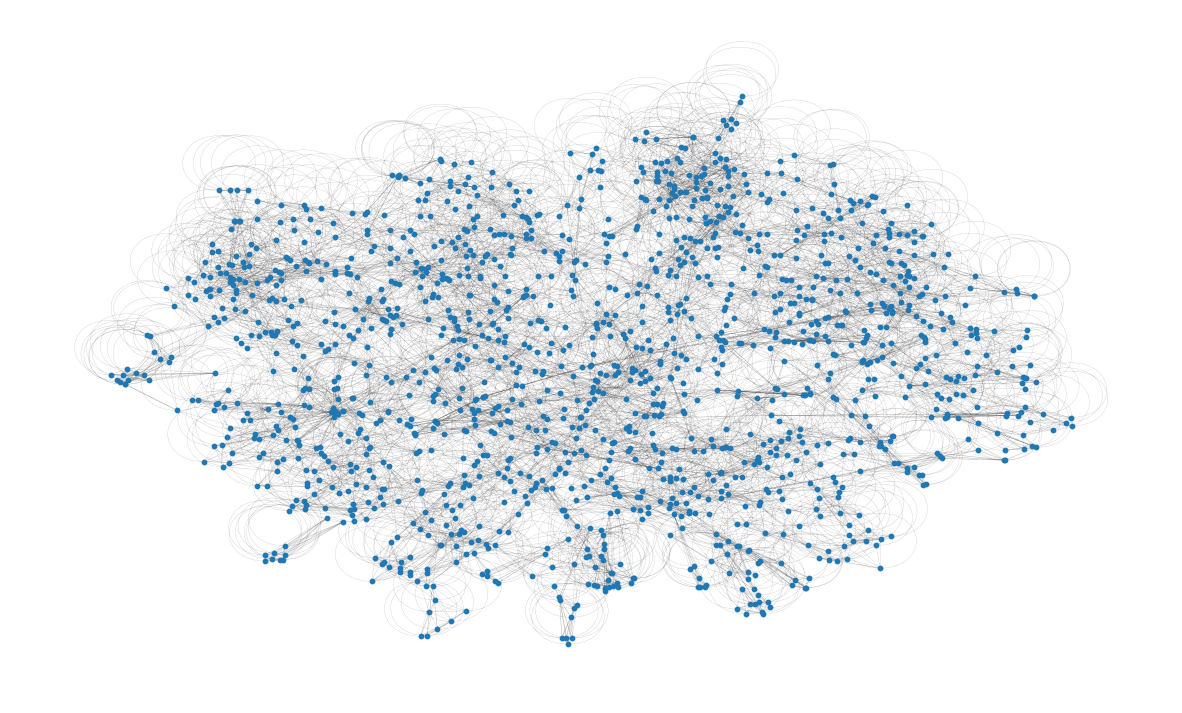

Number of graphs to work upon : 10000
For the FIRST graph in the graph dataset : 
Type of each graph entity data object: <class 'torch_geometric.data.data.Data'>
Number of nodes: 1530
Number of edges: 12240
Number of node features: 5
Number of edges features: 1


In [15]:
G = nx.Graph()
data = graph_dataset[0]
edge_tensor = data.edge_index
edge_list = [(edge_tensor[0, i].item(), edge_tensor[1, i].item()) for i in range(edge_tensor.shape[1])]
G.add_edges_from(edge_list)
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_size=10, with_labels=False, width=0.05)
plt.show()

print(f'Number of graphs to work upon : {len(graph_dataset)}')
print(f'For the FIRST graph in the graph dataset : ')
print(f'Type of each graph entity data object: {type(data)}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of node features: {data.num_node_features}')
print(f'Number of edges features: {data.num_edge_features}')

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class GraphEncoder(nn.Module):
    def __init__(self, point_dim=3, metadata_dim=2, hidden_dim=128, out_dim=64):
        super().__init__()
        self.point_encoder = nn.Sequential(
            nn.Linear(point_dim, hidden_dim // 2),
            nn.ReLU(),
        )
        
        self.metadata_encoder = nn.Sequential(
            nn.Linear(metadata_dim, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
        )
        
        self.conv1 = GATConv(hidden_dim, hidden_dim)
        self.conv2 = GATConv(hidden_dim, hidden_dim)
        self.conv3 = GATConv(hidden_dim, out_dim)

    def forward(self, data):
        point_features = data.x[:, :3]  
        metadata_features = data.x[:, 3:] 
        
        point_emb = self.point_encoder(point_features)
        metadata_emb = self.metadata_encoder(metadata_features)
        
        x = torch.cat([point_emb, metadata_emb], dim=1)
        
        x = F.relu(self.conv1(x, data.edge_index))
        x = F.relu(self.conv2(x, data.edge_index))
        x = self.conv3(x, data.edge_index)
        
    
        return global_mean_pool(x, data.batch)  

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, encoder, projection_dim=32):
        super().__init__()
        self.encoder = encoder  
        
        self.projector = nn.Sequential(
            nn.Linear(64, 128),   
            nn.ReLU(),
            nn.Linear(128, projection_dim),
        )

    def forward(self, graph):
        embedding = self.encoder(graph)  
        projected = self.projector(embedding)  
        return F.normalize(projected, dim=1)  

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Loss(nn.Module):
    def __init__(self, temperature=0.1, hard_neg_weight=0.5):
        super().__init__()
        self.temp = temperature
        self.hard_neg_weight = hard_neg_weight  

    def forward(self, features, labels):
        features = F.normalize(features, dim=1)

        sim_matrix = torch.matmul(features, features.T) / self.temp  
        
        mask = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)).float()
        
        exp_sim = torch.exp(sim_matrix)

        hard_neg_mask = (1 - mask) * (sim_matrix > 0.5).float() 

        log_prob = sim_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True))

        weighted_log_prob = log_prob * (mask + self.hard_neg_weight * hard_neg_mask)

        mean_log_prob = weighted_log_prob.sum(1) / (mask.sum(1) + self.hard_neg_weight * hard_neg_mask.sum(1))
        return -mean_log_prob.mean()

In [19]:
import torch
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

def train(model, train_loader, val_loader, optimizer, criterion,schedular, num_epochs=50, device="cuda"):
    model.to(device)
    
    # Initialize KNN once
    knn = KNeighborsClassifier(n_neighbors=5)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        train_embeddings = []
        train_labels = []
        
        # Training phase
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            projections = model(batch)  
            loss = criterion(projections, batch.y.view(-1))  
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            with torch.no_grad():
                emb = model.encoder(batch).cpu()  
                train_embeddings.append(emb)
                train_labels.append(batch.y.cpu())

        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        
        
        train_embeddings = torch.cat(train_embeddings).numpy()
        train_labels = torch.cat(train_labels).numpy()
        
        knn.fit(train_embeddings, train_labels)
        train_acc = knn.score(train_embeddings, train_labels)
        
        val_acc, val_auc, _, _= evaluate(model, val_loader, knn) if val_loader else 0.0
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Loss: {total_loss / len(train_loader):.4f} | "
              f"Train Acc: {train_acc:.4f} | "
              f"Val Acc: {val_acc:.4f} | "
              f"Val ROC-AUC: {val_auc:.4f}")

In [20]:
import torch
import numpy as np

def evaluate(model, loader, knn, device="cuda"):
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            emb = model.encoder(batch).cpu()  
            embeddings.append(emb)
            labels.append(batch.y.view(-1).cpu())  
    
    if not embeddings:
        return 0.0
    
    embeddings = torch.cat(embeddings).numpy()
    labels = torch.cat(labels).numpy()

    val_acc = knn.score(embeddings, labels)
    
    probs = knn.predict_proba(embeddings)[:, 1]  
    val_auc = roc_auc_score(labels, probs) if len(np.unique(labels)) > 1 else 0.0
    
    fpr, tpr, _ = roc_curve(labels, probs) if len(np.unique(labels)) > 1 else ([], [], [])
    
    return val_acc, val_auc, fpr, tpr

In [21]:
import torch
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if __name__ == "__main__":
    train_size = int(0.8 * len(graph_dataset))
    val_size = len(graph_dataset) - train_size
    train_set, val_set = random_split(graph_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    
    train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=16)

    encoder = GraphEncoder(point_dim=3, metadata_dim=2).to(device)
    model = Model(encoder).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)
    criterion = Loss()

    
    train(model, train_loader, val_loader, optimizer, criterion,scheduler, device=device)

    
    knn = KNeighborsClassifier(n_neighbors=5)
    train_embeddings, train_labels = [], []
    model.eval()
    with torch.no_grad():
        for batch in train_loader:
            batch = batch.to(device)
            emb = model.encoder(batch).cpu()  
            train_embeddings.append(emb)
            train_labels.append(batch.y.cpu())

    
    train_embeddings = torch.cat(train_embeddings).numpy()
    train_labels = torch.cat(train_labels).numpy()

    
    knn.fit(train_embeddings, train_labels)

    test_acc, test_auc, fpr, tpr = evaluate(model, val_loader, knn, device=device)
    print(f"\nFinal Test Accuracy: {test_acc:.4f}")
    print(f"Final Test ROC-AUC: {test_auc:.4f}")

Epoch 1/50 | Loss: 2.7709 | Train Acc: 0.7630 | Val Acc: 0.6390 | Val ROC-AUC: 0.6645
Epoch 2/50 | Loss: 2.7706 | Train Acc: 0.7544 | Val Acc: 0.6180 | Val ROC-AUC: 0.6524
Epoch 3/50 | Loss: 2.7705 | Train Acc: 0.7549 | Val Acc: 0.6350 | Val ROC-AUC: 0.6720
Epoch 4/50 | Loss: 2.7699 | Train Acc: 0.7659 | Val Acc: 0.6350 | Val ROC-AUC: 0.6752
Epoch 5/50 | Loss: 2.7699 | Train Acc: 0.7552 | Val Acc: 0.6385 | Val ROC-AUC: 0.6854
Epoch 6/50 | Loss: 2.7698 | Train Acc: 0.7604 | Val Acc: 0.6625 | Val ROC-AUC: 0.6984
Epoch 7/50 | Loss: 2.7696 | Train Acc: 0.7629 | Val Acc: 0.6615 | Val ROC-AUC: 0.7097
Epoch 8/50 | Loss: 2.7692 | Train Acc: 0.7729 | Val Acc: 0.6025 | Val ROC-AUC: 0.6246
Epoch 9/50 | Loss: 2.7696 | Train Acc: 0.7642 | Val Acc: 0.6725 | Val ROC-AUC: 0.7025
Epoch 10/50 | Loss: 2.7691 | Train Acc: 0.7684 | Val Acc: 0.6865 | Val ROC-AUC: 0.7296
Epoch 11/50 | Loss: 2.7688 | Train Acc: 0.7752 | Val Acc: 0.6525 | Val ROC-AUC: 0.6895
Epoch 12/50 | Loss: 2.7692 | Train Acc: 0.7735 | Val

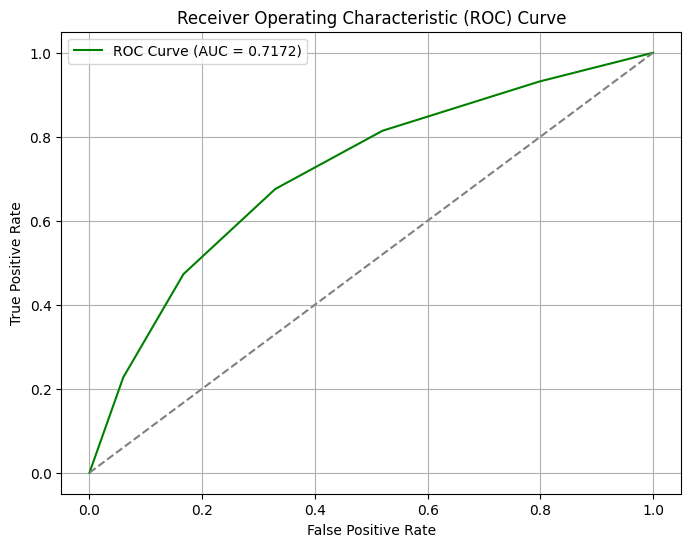

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.4f})', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()